# CNN robustness of CIFAR-10

In this notebook we evaluate the samples we collected over different runs on CIFAR-10.

In [1]:
import os
from jax import numpy as jnp
import numpy as onp
import jax
import tensorflow.compat.v2 as tf
import argparse
import time
import tqdm
from collections import OrderedDict

from bnn_hmc.utils import data_utils
from bnn_hmc.utils import models
from bnn_hmc.utils import metrics
from bnn_hmc.utils import losses
from bnn_hmc.utils import checkpoint_utils
from bnn_hmc.utils import cmd_args_utils
from bnn_hmc.utils import logging_utils
from bnn_hmc.utils import train_utils
from bnn_hmc.utils import precision_utils

from itertools import chain

from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
dtype = jnp.float32
train_set, test_set, task, data_info = data_utils.make_ds_pmap_fullbatch(
    "cifar10", dtype)
test_labels = test_set[1]

net_apply, net_init = models.get_model("lenet", data_info)
net_apply = precision_utils.rewrite_high_precision(net_apply)

(_, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)

In [3]:
def predict_hmc_seeds(ds, path_dict):
    all_preds = {}
    for seed, path in path_dict.items():
        all_preds[seed] = predict_hmc(ds, path)[0].copy()
    return all_preds

def predict_hmc(ds, basepath):
    basepath = os.path.join(basepath, "model_step_{}.pt")
    ensemble_predictions = None
    num_ensembled = 0
    last_test_predictions = None
    for i in tqdm.tqdm(range(11, 100)):
        path = basepath.format(i)
        try:
            checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        except:
            continue
        _, params, net_state, _, _, accepted, _, _ = (
            checkpoint_utils.parse_hmc_checkpoint_dict(checkpoint_dict))
        if accepted:
            _, test_predictions = onp.asarray(
                predict_fn(net_apply, params, net_state, ds))
            ensemble_predictions = ensemble_upd_fn(
                ensemble_predictions, num_ensembled, test_predictions)
            num_ensembled += 1
            last_test_predictions = test_predictions
    print(num_ensembled)
    return ensemble_predictions, last_test_predictions


def predict_de(ds, path_dict):
    ensemble_predictions = None
    num_ensembled = 0
#     last_test_predictions = None
    all_predictions = {}
    for seed, path in tqdm.tqdm(path_dict.items()):
        checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        params = checkpoint_dict["params"]
        net_state = checkpoint_dict["net_state"]
        _, test_predictions = onp.asarray(
            predict_fn(net_apply, params, net_state, ds))
        ensemble_predictions = ensemble_upd_fn(
            ensemble_predictions, num_ensembled, test_predictions)
        num_ensembled += 1
        all_predictions[seed] = test_predictions.copy()
        if num_ensembled >= 10:
            break
    print(num_ensembled)
    return ensemble_predictions, last_test_predictions

## Dirs

In [1]:
gaussdirs = {}
prefix = "../runs/hmc/cifar10/lenet/gaussian/"
dirs = os.listdir(prefix)
for path in dirs:
    full_path = os.path.join(prefix, path)
    wd = float(full_path.split("_")[3])
    stepsize = float(full_path.split("_")[5])
    trajlen = float(full_path.split("_")[7])
#     name = "Gaussian wd={} T=1".format(wd, stepsize)
    gaussdirs[wd] = full_path
        
gaussdirs

In [4]:
sumfilterdirs = {}
# prefix = "../runs/hmc/cifar10/lenet/sumfilter/"
prefix = "../runs/hmc/cifar10/lenet/pca_wd100/"
dirs = os.listdir(prefix)
for path in dirs:
    full_path = os.path.join(prefix, path)
    wd = float(full_path.split("_")[4])
    stepsize = float(full_path.split("_")[6])
    trajlen = float(full_path.split("_")[8])
#     name = "Gaussian wd={} T=1".format(wd, stepsize)
    sumfilterdirs[wd] = full_path
        
sumfilterdirs

{100.0: '../runs/hmc/cifar10/lenet/pca_wd100/model_lenet_wd_100.0_stepsize_3e-05_trajlen_0.15_burnin_10_mh_True_temp_1.0_seed_0'}

In [5]:
sgddirs = {}
prefix = "../runs/sgd/cifar10/lenet/"

dirs = os.listdir(prefix)
for path in dirs:
    if path[:3] != "sgd":
        continue
    full_path = os.path.join(prefix, path, "model_step_299.pt")
    wd = float(full_path.split("_")[13])
    seed = float(full_path.split("_")[-3].split("/")[0])
    if wd not in sgddirs:
        sgddirs[wd] = {}
    sgddirs[wd][seed] = full_path
        
sgddirs

{100.0: {8.0: '../runs/sgd/cifar10/lenet/sgd_mom_0.9__lr_sch_i_1e-07___epochs_300_wd_100.0_batchsize_80_temp_1.0__seed_8/model_step_299.pt',
  5.0: '../runs/sgd/cifar10/lenet/sgd_mom_0.9__lr_sch_i_1e-07___epochs_300_wd_100.0_batchsize_80_temp_1.0__seed_5/model_step_299.pt',
  6.0: '../runs/sgd/cifar10/lenet/sgd_mom_0.9__lr_sch_i_1e-07___epochs_300_wd_100.0_batchsize_80_temp_1.0__seed_6/model_step_299.pt',
  11.0: '../runs/sgd/cifar10/lenet/sgd_mom_0.9__lr_sch_i_1e-07___epochs_300_wd_100.0_batchsize_80_temp_1.0__seed_11/model_step_299.pt',
  2.0: '../runs/sgd/cifar10/lenet/sgd_mom_0.9__lr_sch_i_1e-07___epochs_300_wd_100.0_batchsize_80_temp_1.0__seed_2/model_step_299.pt',
  4.0: '../runs/sgd/cifar10/lenet/sgd_mom_0.9__lr_sch_i_1e-07___epochs_300_wd_100.0_batchsize_80_temp_1.0__seed_4/model_step_299.pt',
  10.0: '../runs/sgd/cifar10/lenet/sgd_mom_0.9__lr_sch_i_1e-07___epochs_300_wd_100.0_batchsize_80_temp_1.0__seed_10/model_step_299.pt',
  3.0: '../runs/sgd/cifar10/lenet/sgd_mom_0.9__lr_s

In [6]:
arr = onp.load("cifar10_patch_pca.npz")

pca = {
    "basis": arr["components"],
    "mean": arr["mean"],
    "explained_var_ratio": arr["explained_var_ratio"]
}



layer_pcas = {
    'conv2_d': pca,
    'conv2_d_1': None,
    'linear': None,
    'linear_1': None,
    'linear_2': None,
}


def get_n_components(rel_explained_vars, cutoff):
    cumsum = onp.cumsum(rel_explained_vars)
    n_components = onp.where(cumsum > cutoff)[0][0]
    return n_components


def pca_ajust_layer(params, layer_name, conv_cutoff, linear_cutoff):
    is_conv = layer_name[:5] == "conv2"
    w = onp.asarray(params[layer_name]["w"])
    b = onp.asarray(params[layer_name]["b"])
    original_shape = w.shape
    
    pca_dict = layer_pcas[layer_name]
    if pca_dict is None:
        return w, b
    basis = pca_dict["basis"]
    mean = pca_dict["mean"]
    explained_var_ratio = pca_dict["explained_var_ratio"]
    
    cutoff = conv_cutoff if is_conv else linear_cutoff
    n_components = get_n_components(explained_var_ratio, cutoff)
    basis = basis[:n_components]
    print("{}  \tRetained components: {} / {}".format(
        layer_name, n_components, basis.shape[1]))
    
    if is_conv:
        ks, _, i_c, o_c = w.shape
        w = w.reshape((ks**2 * i_c, -1))
        w = w.transpose(1, 0)
#         print(w.shape, basis.shape, mean.shape)
        original_w_mean = (w * mean[None, :]).sum()
        w = (w) @ basis.T @ basis
        new_w_mean = (w * mean[None, :]).sum()
        w = w.transpose(1, 0)
        w = w.reshape(original_shape)
    else:
        w = w.transpose(1, 0)
        original_w_mean = w @ mean
        w = w @ basis.T @ basis
        new_w_mean = w @ mean
        w = w.transpose(1, 0)
        
    bias_shift = original_w_mean - new_w_mean
#     print(bias_shift)
    b = b + bias_shift
    return w, b


# w = pca_ajust_layer(params, 'conv2_d')
# w = pca_ajust_layer(params, 'conv2_d_1')
# w = pca_ajust_layer(params, 'linear')
# w = pca_ajust_layer(params, 'linear_1')
# w = pca_ajust_layer(params, 'linear_2')
        

def adjust_pca_projections(params, conv_cutoff=0.99, linear_cutoff=0.9):
    params_flat, treedef = jax.tree_flatten(params)
    new_params = {layer_name: {p: v for p, v in layer_dict.items()}
                  for layer_name, layer_dict in params.items()}
    
    for layer_name in layer_pcas.keys():
        w, b = pca_ajust_layer(params, layer_name, conv_cutoff, linear_cutoff)
        new_params[layer_name]["w"] = jnp.asarray(w)
        new_params[layer_name]["b"] = jnp.asarray(b)
    
    new_params_flat, _ = jax.tree_flatten(new_params)
    new_params = jax.tree_unflatten(treedef, new_params_flat)
    return new_params

In [7]:

def predict_hmc(ds, basepath, adjust_pca=False):
    basepath = os.path.join(basepath, "model_step_{}.pt")
    ensemble_predictions = None
    num_ensembled = 0
    last_test_predictions = None
    for i in tqdm.tqdm(range(11, 100)):
        path = basepath.format(i)
        try:
            checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        except:
            continue
        _, params, net_state, _, _, accepted, _, _ = (
            checkpoint_utils.parse_hmc_checkpoint_dict(checkpoint_dict))
        if adjust_pca:
            params = adjust_pca_projections(params)
#             return None
        if accepted:
            _, test_predictions = onp.asarray(
                predict_fn(net_apply, params, net_state, ds))
            ensemble_predictions = ensemble_upd_fn(
                ensemble_predictions, num_ensembled, test_predictions)
            num_ensembled += 1
            last_test_predictions = test_predictions
    print(num_ensembled)
    return ensemble_predictions, last_test_predictions


def predict_de(ds, path_dict, adjust_pca=False):
    ensemble_predictions = None
    num_ensembled = 0
    last_test_predictions = None
    for path in tqdm.tqdm(path_dict.values()):
        checkpoint_dict = checkpoint_utils.load_checkpoint(path)
        params = checkpoint_dict["params"]
        net_state = checkpoint_dict["net_state"]
        _, test_predictions = onp.asarray(
            predict_fn(net_apply, params, net_state, ds))
        ensemble_predictions = ensemble_upd_fn(
            ensemble_predictions, num_ensembled, test_predictions)
        num_ensembled += 1
        last_test_predictions = test_predictions
    print(num_ensembled)
    return ensemble_predictions, last_test_predictions

In [9]:
# hmc_predictions, predictions = predict_hmc(test_set, gaussdirs[100], adjust_pca=True)
# print(metrics.accuracy(hmc_predictions, test_labels))

## CIFAR-10-C

In [17]:
from bnn_hmc.utils import data_utils
import tensorflow_datasets as tfds

all_corruptions = tfds.image_classification.cifar10_corrupted._CORRUPTIONS

In [18]:
all_corruptions

('brightness',
 'contrast',
 'defocus_blur',
 'elastic',
 'fog',
 'frost',
 'frosted_glass_blur',
 'gaussian_blur',
 'gaussian_noise',
 'impulse_noise',
 'jpeg_compression',
 'motion_blur',
 'pixelate',
 'saturate',
 'shot_noise',
 'snow',
 'spatter',
 'speckle_noise',
 'zoom_blur')

In [19]:
def load_image_dataset(
    split, batch_size, name, repeat=False, shuffle=False,
    shuffle_seed=None
):
    ds, dataset_info = tfds.load(name, split=split, as_supervised=True,
                               with_info=True)
    num_classes = dataset_info.features["label"].num_classes
    num_examples = dataset_info.splits[split].num_examples
    num_channels = dataset_info.features['image'].shape[-1]
    
    def img_to_float32(image, label):
        return tf.image.convert_image_dtype(image, tf.float32), label

    ds = ds.map(img_to_float32).cache()
    ds_stats = data_utils._ALL_IMG_DS_STATS[data_utils.ImgDatasets("cifar10")]
    def img_normalize(image, label):
        """Normalize the image to zero mean and unit variance."""
        mean, std = ds_stats
        image -= tf.constant(mean, shape=[1, 1, num_channels], dtype=image.dtype)
        image /= tf.constant(std, shape=[1, 1, num_channels], dtype=image.dtype)
        return image, label

    ds = ds.map(img_normalize)
    if batch_size == -1:
        batch_size = num_examples
    if repeat:
        ds = ds.repeat()
    if shuffle:
        ds = ds.shuffle(buffer_size=10 * batch_size, seed=shuffle_seed)
    ds = ds.batch(batch_size)
    return tfds.as_numpy(ds), num_classes, num_examples


def get_image_dataset(name):

    test_set, n_classes, _ = load_image_dataset("test", -1, name)
    test_set = next(iter(test_set))
    
    data_info = {
        "num_classes": n_classes
    }

    return test_set, data_info


def pmap_dataset(ds, n_devices):
    return jax.pmap(lambda x: x)(data_utils.batch_split_axis(ds, n_devices))


def make_cifar10c_pmap_fullbatch(corruption, intensity, dtype, n_devices=None, truncate_to=None):
    """Make train and test sets sharded over batch dim."""
    name = get_ds_name(corruption, intensity).lower()
    n_devices = n_devices or len(jax.local_devices())
    test_set, data_info = get_image_dataset(name)
    loaded = True
    test_set = pmap_dataset(test_set, n_devices)

    test_set = test_set[0].astype(dtype), test_set[1]

    return test_set, task, data_info


def get_ds_name(corruption, intensity):
    return "cifar10_corrupted/{}_{}".format(corruption, intensity)
    

dtype = jnp.float32
test_set, task, data_info = make_cifar10c_pmap_fullbatch(all_corruptions[0], 3, dtype)
test_labels = test_set[1]

net_apply, net_init = models.get_model("lenet", data_info)
net_apply = precision_utils.rewrite_high_precision(net_apply)
(_, predict_fn, ensemble_upd_fn, _,_) = train_utils.get_task_specific_fns(task, data_info)

In [20]:
prior_dirs = {
    "gauss": gaussdirs,
    "sumfilter": sumfilterdirs
}

sgd_ind_accs = {key: {} for key in sgddirs}
sgd_ens_accs = {key: {} for key in sgddirs}
hmc_ind_accs = {prior: {key: {} for key in dirs} 
                for prior, dirs in prior_dirs.items()}
hmc_ens_accs = {prior: {key: {} for key in dirs} 
                for prior, dirs in prior_dirs.items()}
pca_hmc_ind_accs = {prior: {key: {} for key in dirs} 
                for prior, dirs in prior_dirs.items()}
pca_hmc_ens_accs = {prior: {key: {} for key in dirs} 
                for prior, dirs in prior_dirs.items()}


for corruption in all_corruptions:
    for intensity in [3]:
        noisy_test_set, _, _ = make_cifar10c_pmap_fullbatch(corruption, intensity, dtype)
        test_labels = noisy_test_set[1]
        
        for prior, dirs in prior_dirs.items():
            for key, path in dirs.items():
                hmc_predictions, predictions = predict_hmc(noisy_test_set, path)
                if hmc_predictions is None:
                    continue
                hmc_ens_accs[prior][key][corruption, intensity] = metrics.accuracy(hmc_predictions, test_labels)
                hmc_ind_accs[prior][key][corruption, intensity] = metrics.accuracy(predictions, test_labels)
                
#                 hmc_predictions, predictions = predict_hmc(noisy_test_set, path, adjust_pca=True)
#                 if hmc_predictions is None:
#                     continue
#                 pca_hmc_ens_accs[prior][key][corruption, intensity] = metrics.accuracy(hmc_predictions, test_labels)
#                 pca_hmc_ind_accs[prior][key][corruption, intensity] = metrics.accuracy(predictions, test_labels)

        for key, pathdict in sgddirs.items():
            de_predictions, predictions = predict_de(noisy_test_set, pathdict)
            sgd_ind_accs[key][corruption, intensity] = metrics.accuracy(predictions, test_labels)
            sgd_ens_accs[key][corruption, intensity] = metrics.accuracy(de_predictions, test_labels)

  0%|          | 0/89 [00:00<?, ?it/s]/home/pavel/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 89/89 [00:09<00:00,  9.50it/s]


74


100%|██████████| 10/10 [00:00<00:00, 122.10it/s]


78
10


 13%|█▎        | 12/89 [00:00<00:00, 117.42it/s]

74


100%|██████████| 10/10 [00:00<00:00, 108.22it/s]


78
10


 13%|█▎        | 12/89 [00:00<00:00, 111.93it/s]

74


100%|██████████| 10/10 [00:00<00:00, 117.13it/s]


78
10


 13%|█▎        | 12/89 [00:00<00:00, 115.82it/s]

74


100%|██████████| 10/10 [00:00<00:00, 113.88it/s]


78
10


 13%|█▎        | 12/89 [00:00<00:00, 119.48it/s]

74


100%|██████████| 10/10 [00:00<00:00, 114.21it/s]


78
10


 13%|█▎        | 12/89 [00:00<00:00, 112.53it/s]

74


100%|██████████| 10/10 [00:00<00:00, 118.27it/s]


78
10


 15%|█▍        | 13/89 [00:00<00:00, 126.54it/s]

74


100%|██████████| 10/10 [00:00<00:00, 123.33it/s]


78
10


 15%|█▍        | 13/89 [00:00<00:00, 125.06it/s]

74


100%|██████████| 10/10 [00:00<00:00, 118.33it/s]


78
10


 12%|█▏        | 11/89 [00:00<00:00, 105.84it/s]

74


100%|██████████| 10/10 [00:00<00:00, 119.68it/s]


78
10


 15%|█▍        | 13/89 [00:00<00:00, 121.95it/s]

74


100%|██████████| 10/10 [00:00<00:00, 109.35it/s]


78
10


 13%|█▎        | 12/89 [00:00<00:00, 115.60it/s]

74


100%|██████████| 10/10 [00:00<00:00, 119.14it/s]


78
10


 13%|█▎        | 12/89 [00:00<00:00, 115.87it/s]

74


100%|██████████| 10/10 [00:00<00:00, 110.70it/s]


78
10


 15%|█▍        | 13/89 [00:00<00:00, 123.66it/s]

74


100%|██████████| 10/10 [00:00<00:00, 110.12it/s]


78
10


 15%|█▍        | 13/89 [00:00<00:00, 120.28it/s]

74


100%|██████████| 10/10 [00:00<00:00, 108.00it/s]


78
10


 15%|█▍        | 13/89 [00:00<00:00, 125.00it/s]

74


100%|██████████| 10/10 [00:00<00:00, 121.80it/s]


78
10


 13%|█▎        | 12/89 [00:00<00:00, 117.14it/s]

74


100%|██████████| 10/10 [00:00<00:00, 110.10it/s]


78
10


 13%|█▎        | 12/89 [00:00<00:00, 115.83it/s]

74


100%|██████████| 10/10 [00:00<00:00, 121.24it/s]


78
10


 15%|█▍        | 13/89 [00:00<00:00, 124.76it/s]

74


100%|██████████| 10/10 [00:00<00:00, 121.52it/s]


78
10


 13%|█▎        | 12/89 [00:00<00:00, 113.32it/s]

74


100%|██████████| 10/10 [00:00<00:00, 117.35it/s]

78
10


In [21]:
datasets = ["CIFAR10", "stl10_like_cifar"]


for ds_name in datasets:
    dtype = jnp.float32
    train_set, test_set, task, data_info = data_utils.make_ds_pmap_fullbatch(
        ds_name, dtype)
    test_labels = test_set[1]


    for prior, dirs in prior_dirs.items():
        for key, path in dirs.items():
            hmc_predictions, predictions = predict_hmc(test_set, path)
            if hmc_predictions is None:
                continue
            for intensity in range(1, 6):
                hmc_ens_accs[prior][key][ds_name.upper(), intensity] = metrics.accuracy(hmc_predictions, test_labels)
                hmc_ind_accs[prior][key][ds_name.upper(), intensity] = metrics.accuracy(predictions, test_labels)
                
#             hmc_predictions, predictions = predict_hmc(test_set, path, adjust_pca=True)
#             for intensity in range(1, 6):
#                 pca_hmc_ens_accs[prior][key][ds_name.upper(), intensity] = metrics.accuracy(hmc_predictions, test_labels)
#                 pca_hmc_ind_accs[prior][key][ds_name.upper(), intensity] = metrics.accuracy(predictions, test_labels)
                
    for corruption in datasets:
        de_predictions, predictions = predict_de(test_set, pathdict)
        for intensity in range(1, 6):
            sgd_ind_accs[key][ds_name.upper(), intensity] = metrics.accuracy(predictions, test_labels)
            sgd_ens_accs[key][ds_name.upper(), intensity] = metrics.accuracy(de_predictions, test_labels)

 13%|█▎        | 12/89 [00:00<00:00, 119.87it/s]

74


  0%|          | 0/10 [00:00<?, ?it/s]

78
10


100%|██████████| 10/10 [00:00<00:00, 111.94it/s]


10


/home/pavel/google-research/bnn_hmc/utils/data_utils.py:296: UserWarning: Dataset of length 4500 can not be split onto 8 devices.Truncating to 4496 data points.
  warnings.warn(warning_str, UserWarning)
100%|██████████| 89/89 [00:03<00:00, 25.86it/s]


74


  0%|          | 0/10 [00:00<?, ?it/s]

78
10


100%|██████████| 10/10 [00:00<00:00, 115.40it/s]

10


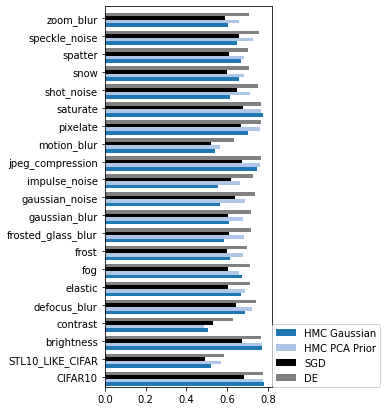

In [23]:
cmap = matplotlib.cm.get_cmap("tab20")

num_bars = 4
width = 0.8 / num_bars

plt.figure(figsize=(3, 7))
all_corruptions_ = onp.unique([k[0] for k in hmc_ens_accs["gauss"][100.]])

ys = onp.arange(len(all_corruptions_))

std = onp.sqrt(1 / wd)
plt.barh(ys, [hmc_ens_accs["gauss"][wd][c, 3] for c in all_corruptions_],
    height=width, label="HMC Gaussian".format(std), color=cmap(0)
)
plt.barh(ys + width, [hmc_ens_accs["sumfilter"][wd][c, 3] for c in all_corruptions_],
    height=width, label="HMC PCA Prior".format(std), color=cmap(1)
)
# plt.barh(ys + width, [pca_hmc_ens_accs["gauss"][wd][c, 3] for c in all_corruptions_],
#     height=width, label="HMC PCA".format(std), color=cmap(1)
# )
    
plt.barh(ys + 2 * width, [sgd_ind_accs[100][c, 3] for c in all_corruptions_],
        height=width, label="SGD", color="k" #cmap(len(wds)+1)
    )
plt.barh(ys + 3 * width, [sgd_ens_accs[100][c, 3] for c in all_corruptions_],
        height=width, label="DE", color="grey" #cmap(len(wds)+1)
    )

plt.ylim(-0.15, 21.05)
plt.legend(loc=(1, 0))
plt.yticks(ys+0.4, all_corruptions_, rotation=0);
# plt.savefig("gaussian_priors_mnistc.pdf", bbox_inches="tight")

## Filter visualization

In [18]:
# path = os.path.join(gaussdirs[100.], "model_step_90.pt")
path = os.path.join(sumfilterdirs[100.], "model_step_12.pt")

checkpoint_dict = checkpoint_utils.load_checkpoint(path)
_, params, net_state, _, _, accepted, _, _ = (
    checkpoint_utils.parse_hmc_checkpoint_dict(checkpoint_dict))

In [19]:
params.keys()

KeysOnlyKeysView(['conv2_d', 'conv2_d_1', 'linear', 'linear_1', 'linear_2'])

(5, 5, 3, 6)


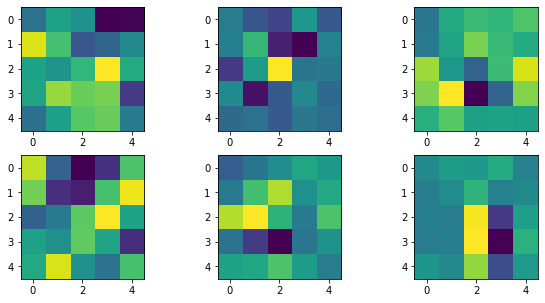

In [20]:
w = params['conv2_d']['w']
print(w.shape)

f, arr = plt.subplots(2, 3, figsize=(10, 5))
for i in range(2):
    for j in range(3):
        arr[i, j].imshow(w[:, :, 0, i + 2 * j])

(576, 120)


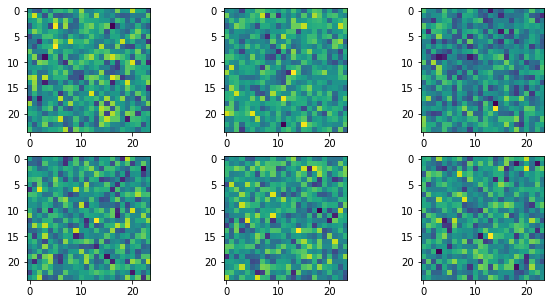

In [21]:
w = params['linear']['w']
print(w.shape)

f, arr = plt.subplots(2, 3, figsize=(10, 5))
for i in range(2):
    for j in range(3):
        arr[i, j].imshow(w[:, i + 2 * j].reshape(24, 24))

### SGD

In [22]:
path = sgddirs[100.][2.0]
checkpoint_dict = checkpoint_utils.load_checkpoint(path)
_, params, net_state, _, _ = (
    checkpoint_utils.parse_sgd_checkpoint_dict(checkpoint_dict))

(5, 5, 6, 16)


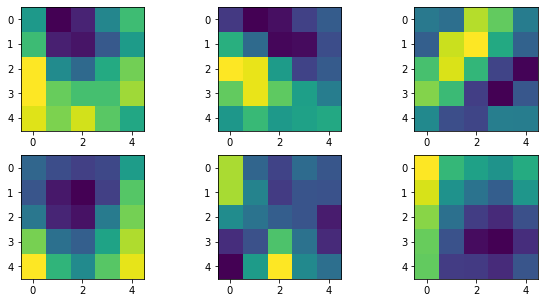

In [23]:
w = params['conv2_d_1']['w']
print(w.shape)

f, arr = plt.subplots(2, 3, figsize=(10, 5))
for i in range(2):
    for j in range(3):
        arr[i, j].imshow(w[:, :, 0, i + 2 * j])

(576, 120)


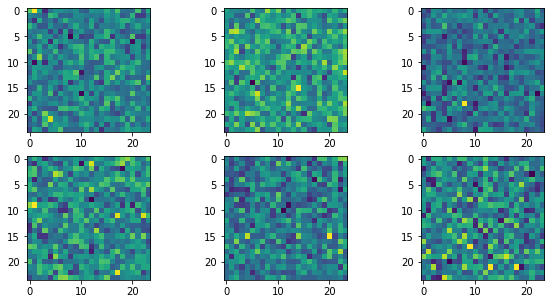

In [49]:
w = params['linear']['w']
print(w.shape)

f, arr = plt.subplots(2, 3, figsize=(10, 5))
for i in range(2):
    for j in range(3):
        arr[i, j].imshow(w[:, i + 2 * j].reshape(24, 24))

In [111]:
sgd_effective_sigmas = jax.tree_map(lambda p: jnp.linalg.norm(p) / jnp.sqrt(p.size), params)
sgd_effective_sigmas

FlatMapping({
  'conv2_d': FlatMapping({
               'b': DeviceArray(0.17039812, dtype=float32),
               'w': DeviceArray(0.28325346, dtype=float32),
             }),
  'conv2_d_1': FlatMapping({
                 'b': DeviceArray(0.02292008, dtype=float32),
                 'w': DeviceArray(0.07301848, dtype=float32),
               }),
  'linear': FlatMapping({
              'b': DeviceArray(0.00609982, dtype=float32),
              'w': DeviceArray(0.01783383, dtype=float32),
            }),
  'linear_1': FlatMapping({
                'b': DeviceArray(0.01093635, dtype=float32),
                'w': DeviceArray(0.03525899, dtype=float32),
              }),
  'linear_2': FlatMapping({
                'b': DeviceArray(0.01835718, dtype=float32),
                'w': DeviceArray(0.12083421, dtype=float32),
              }),
})

## Weight PCA Projections

In [8]:
wd = 100
prior_std = 1 / onp.sqrt(wd)

In [9]:
w = None
base_path = os.path.join(gaussdirs[100.], "model_step_{}.pt")
for step in range(20, 99):
    path = base_path.format(step)
    checkpoint_dict = checkpoint_utils.load_checkpoint(path)
    if checkpoint_dict["accepted"]:
        params = checkpoint_dict["params"]
        cur_w = onp.asarray(params["conv2_d"]["w"].reshape((75, -1)))
        cur_w = cur_w.transpose(1, 0)
        if w is None:
            w = cur_w.copy()
        else:
            w = onp.concatenate([w, cur_w.copy()], axis=0)

In [10]:
arr = onp.load("cifar10_patch_pca.npz")
basis = arr["components"]

In [11]:
projections = (w[:, None, :] * basis[None, :, :]).sum(-1)
mean = onp.mean(projections, axis=0)
std = onp.std(projections, axis=0)

Text(0.5, 1.0, 'HMC samples, wd=100')

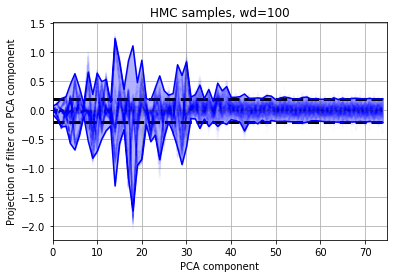

In [12]:
plt.plot(mean + 2 * std, "b")
plt.plot(mean - 2 * std, "b")
plt.fill_between(onp.arange(75), mean + 2 * std, mean - 2 * std, color="b", alpha=0.3)
for p in projections:
    plt.plot(p, "--b", alpha=0.02)
plt.grid()

plt.hlines(2 * prior_std, 0, 75, color="k", linestyle="dashed", lw=3)
plt.hlines(-2 * prior_std, 0, 75, color="k", linestyle="dashed", lw=3)

plt.xlim(0, 75)
plt.xlabel("PCA component")
plt.ylabel("Projection of filter on PCA component")
plt.title("HMC samples, wd={}".format(wd))

## Sum-filter / pca prior

In [13]:
w = None
base_path = os.path.join(sumfilterdirs[100.], "model_step_{}.pt")
for step in range(20, 99):
    path = base_path.format(step)
    checkpoint_dict = checkpoint_utils.load_checkpoint(path)
    if checkpoint_dict["accepted"]:
        params = checkpoint_dict["params"]
        cur_w = onp.asarray(params["conv2_d"]["w"].reshape((75, -1)))
        cur_w = cur_w.transpose(1, 0)
        if w is None:
            w = cur_w.copy()
        else:
            w = onp.concatenate([w, cur_w.copy()], axis=0)

In [15]:
projections = (w[:, None, :] * basis[None, :, :]).sum(-1)
mean = onp.mean(projections, axis=0)
std = onp.std(projections, axis=0)

Text(0.5, 1.0, 'HMC samples, wd=100')

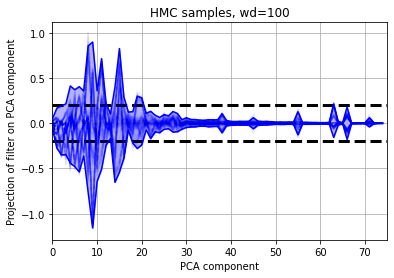

In [16]:
plt.plot(mean + 2 * std, "b")
plt.plot(mean - 2 * std, "b")
plt.fill_between(onp.arange(75), mean + 2 * std, mean - 2 * std, color="b", alpha=0.3)
for p in projections:
    plt.plot(p, "--b", alpha=0.02)
plt.grid()

plt.hlines(2 * prior_std, 0, 75, color="k", linestyle="dashed", lw=3)
plt.hlines(-2 * prior_std, 0, 75, color="k", linestyle="dashed", lw=3)

plt.xlim(0, 75)
plt.xlabel("PCA component")
plt.ylabel("Projection of filter on PCA component")
plt.title("HMC samples, wd={}".format(wd))